Observed Flux Ratios: [1.0, 0.79, 0.41, 0.25]
Predicted Magnifications (Obs Pos): [8.507766177881246, 6.066297409626367, 10.32893052202923, 3.9271226981235046]
Predicted Magnifications (Pred Pos): [181.5755, 157.6498, 81.9358, 36.5937]
Predicted Flux Ratios (Obs Pos): [1.0, 0.7130305749819166, 1.2140590498223498, 0.4615926926075331]
Predicted Flux Ratios (Pred Pos): [1.0, 0.868232773694689, 0.4512492048762085, 0.2015343479709542]
Red Image:
    Min Magnification within 0.01 error (normalized): 0.9782985851112074
    Max Magnification within 0.01 error (normalized): 1.022014315540488
    Flux Ratio Error: 0.05
Green Image:
    Min Magnification within 0.01 error (normalized): 0.7000503208508928
    Max Magnification within 0.01 error (normalized): 0.7264118285739019
    Flux Ratio Error: 0.04
Yellow Image:
    Min Magnification within 0.01 error (normalized): 1.1913921260418137
    Max Magnification within 0.01 error (normalized): 1.2370886152281206
    Flux Ratio Error: 0.04
Blue Image

Text(0.5, 0.98, 'Lens SIE (Shear): Position and flux constrained')

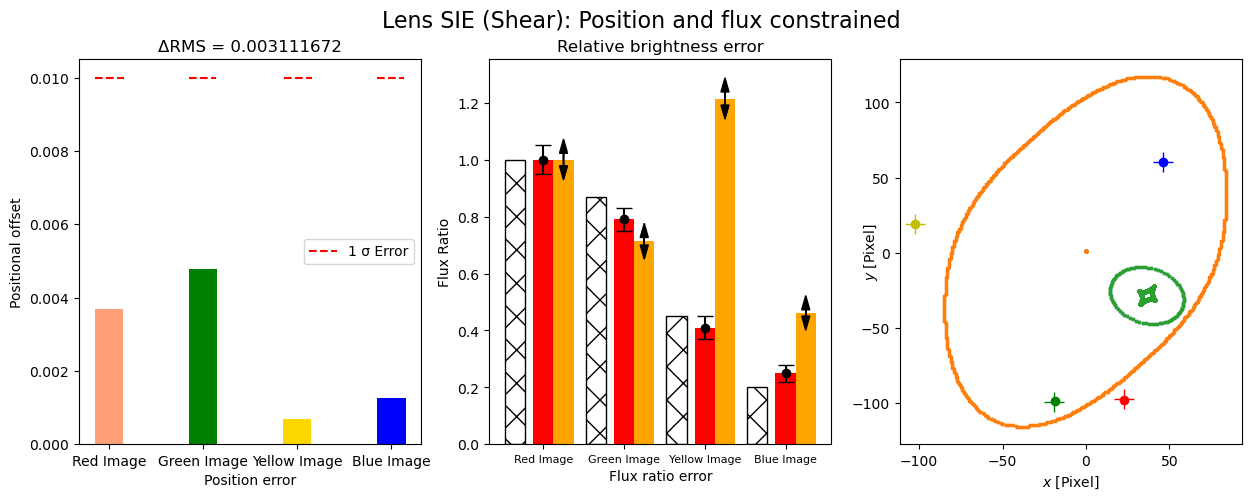

In [3]:
# FIXED GLAFIC PLOTTING CODE!!!
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os

# Define file paths
input_file = "SPFC/Robs_point.dat"
output_file = "SPFC/outSPFR_point.dat"
fits_file = "SPFC/outSPFR_lens.fits"
Critical_Curve = "SPFC/outSPFR_crit.dat"

n = 0.01

# Function to calculate distance
def calculate_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Function to read observed positions, flux ratio errors, and observed flux ratios
def read_observed_positions(input_file):
    observed_positions = []
    flux_ratio_errors = []
    observed_flux_ratios = []
    with open(input_file, 'r') as observed_file:
        observed_lines = observed_file.readlines()[1:]  # Skip the first line
        for line in observed_lines:
            columns = line.split()
            if len(columns) >= 5:
                x1 = float(columns[0])
                y1 = float(columns[1])
                flux_ratio = float(columns[2])  # Extract flux ratio from the third column
                observed_positions.append((x1, y1))
                flux_ratio_errors.append(float(columns[4]))  # Extract flux ratio error
                observed_flux_ratios.append(flux_ratio)
    return observed_positions, flux_ratio_errors, observed_flux_ratios

# Function to read predicted positions and magnifications
def read_predicted_positions(output_file):
    predicted_positions = []
    predicted_magnifications = []
    with open(output_file, 'r') as predicted_file:
        predicted_lines = predicted_file.readlines()[1:]  # Skip the first line
        for line in predicted_lines:
            if line.startswith("#"):
                continue  # Skip comment lines
            columns = line.split()
            if len(columns) >= 3:
                x2 = float(columns[0])
                y2 = float(columns[1])
                M2 = abs(float(columns[2]))  # Take the absolute value of the magnification
                predicted_positions.append((x2, y2))
                predicted_magnifications.append(M2)
    return predicted_positions, predicted_magnifications

# Read observed and predicted data
observed_positions, flux_ratio_errors, observed_flux_ratios = read_observed_positions(input_file)
predicted_positions, predicted_magnifications = read_predicted_positions(output_file)

# Function to pair predicted and observed positions
def pair_positions(observed_positions, predicted_positions, predicted_magnifications):
    paired_positions = []
    for observed_position in observed_positions:
        min_distance = float('inf')
        closest_index = None
        for i, predicted_position in enumerate(predicted_positions):
            distance = calculate_distance(*observed_position, *predicted_position)
            if distance < min_distance:
                min_distance = distance
                closest_index = i
        paired_positions.append((observed_position, predicted_positions[closest_index], predicted_magnifications[closest_index]))
    return paired_positions

#--- 
# Pair observed and predicted positions based on closeness
paired_positions = []
for i, observed_position in enumerate(observed_positions):
    min_distance = float('inf')
    closest_predicted = None
    for predicted_position in predicted_positions:
        distance = abs(observed_position[0] - predicted_position[0]) + abs(observed_position[1] - predicted_position[1])
        if distance < min_distance:
            min_distance = distance
            closest_predicted = predicted_position
    paired_positions.append((observed_position, closest_predicted))

# Define pair names
pair_names = ["Red Image", "Green Image", "Yellow Image", "Blue Image"]
    
# Populate image_coordinates dictionary
image_coordinates = {}
for i, pair in enumerate(paired_positions):
    image_coordinates[pair_names[i]] = (*pair[0], *pair[1])

# Calculate the distances and ΔRMS
distances = []
squared_distances = 0.0  # Initialize the sum of squared distances
colors = ['lightsalmon', 'green', 'gold', 'blue']

for image, coordinates in image_coordinates.items():
    x1, y1, x2, y2 = coordinates
    distance = calculate_distance(x1, y1, x2, y2)
    distances.append(distance)
    squared_distances += distance ** 2  # Sum the squared distances

mean_squared_distances = squared_distances / len(image_coordinates)  # Calculate the mean of squared distances
delta_rms = np.sqrt(mean_squared_distances)  # Calculate the root mean square

# Plotting positional offset
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(image_coordinates.keys(), distances, color=colors, width=0.3)
axs[0].axhline(y=0.01, xmin=0.045, xmax=0.13, color='r', linestyle='dashed', label="1 σ Error")
axs[0].axhline(y=0.01, xmin=0.32, xmax=0.4, color='r', linestyle='dashed')
axs[0].axhline(y=0.01, xmin=0.6, xmax=0.68, color='r', linestyle='dashed')
axs[0].axhline(y=0.01, xmin=0.87, xmax=0.95, color='r', linestyle='dashed')
axs[0].set_xlabel("Position error")
axs[0].set_ylabel("Positional offset")
axs[0].set_title(f"ΔRMS = {delta_rms:.9f}")
axs[0].legend()

# Pair positions
paired_positions = pair_positions(observed_positions, predicted_positions, predicted_magnifications)

# Order predicted positions and magnifications
predicted_positions_ordered = [pair[1] for pair in paired_positions]
predicted_magnifications_ordered = [pair[2] for pair in paired_positions]

# Store the paired positions to pass to the second section
paired_positions_second_section = paired_positions

#---- Flux Ratios

# Function to read and process the FITS file for observed values
def process_fits_file(fits_file, observed_positions, green_image_index=0):
    with fits.open(fits_file) as hdul:
        Mag = hdul[0].data[6]
        
        image_size = Mag.shape
        center_x = image_size[1] // 2
        center_y = image_size[0] // 2
        pixel_coords = [(int((x + center_x * n) / n), int((y + center_y * n) / n)) for x, y in observed_positions]
        
        values = [Mag[y, x] for x, y in pixel_coords]
        abs_values = [1 / abs(value) for value in values]
        return abs_values, pixel_coords, image_size, Mag

# Process FITS file
abs_values, pixel_coords, image_size, Mag = process_fits_file(fits_file, observed_positions)

# Function to calculate flux ratios and magnifications within error bounds
def calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag, green_image_index=0): # CHOOSE IMAGE TO NORMALISE BY HERE! 
    # Calculate flux ratios
    normalization_value = predicted_magnifications_ordered[green_image_index]
    predicted_flux_ratios = [magnification / normalization_value for magnification in predicted_magnifications_ordered]

    # Calculate flux ratios at the observed position 
    predicted_flux_ratios_observed = [abs_values[i] / abs_values[green_image_index] for i in range(len(abs_values))]
    
    # Calculate the circular range for each position
    error = 0.01
    value_ranges = []
    for x, y in pixel_coords:
        x_min = int(max(0, x - error / n))
        x_max = int(min(image_size[1] - 1, x + error / n))
        y_min = int(max(0, y - error / n))
        y_max = int(min(image_size[0] - 1, y + error / n))
        value_range = Mag[y_min : y_max + 1, x_min : x_max + 1]
        value_ranges.append(value_range)
    
    # Find the maximum and minimum values within each circular range
    max_values = [1 / np.min(np.abs(range_vals)) for range_vals in value_ranges]
    min_values = [1 / np.max(np.abs(range_vals)) for range_vals in value_ranges]
    
    # Automatically use the green_image_index position for normalization
    normalization_coord = pixel_coords[green_image_index]
    index = pixel_coords.index(normalization_coord)
    
    # Divide the base value by all other values
    divided_values = [abs_value / abs_values[index] for abs_value in abs_values]
    max_values = [max_value / abs_values[index] for max_value in max_values]
    min_values = [min_value / abs_values[index] for min_value in min_values]
    
    return predicted_flux_ratios, predicted_flux_ratios_observed, list(zip(min_values, max_values))

# Calculate flux ratios and min/max magnifications
predicted_flux_ratios, predicted_flux_ratios_observed, min_max_magnifications = calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag)

# ------------- Plotting Flux ratio ---------- 

# Set width of bar
barWidth = 0.25

# Define the bar width and create the arrays
br1 = np.arange(len(observed_flux_ratios))
br2 = [x + barWidth for x in br1]
br3 = [x + 2 * barWidth for x in br1]

# Switch the positions of br1 and br2
br1, br2 = br2, br1

# Make the plot
axs[1].bar(br1, observed_flux_ratios, color='red', width=barWidth, label='μ_obs/μ_ref')
axs[1].bar(br2-0.1, predicted_flux_ratios, color='white', edgecolor='black', hatch='\\/', width=barWidth, label='μ_pred/μ_ref')
axs[1].bar(br3, predicted_flux_ratios_observed, color='orange', width=barWidth, label='µ_pred/μ_ref (obs pos)')

axs[1].set_xlabel('Flux ratio error', fontsize=10)
axs[1].set_ylabel('Flux Ratio', fontsize=10)
axs[1].set_xticks([r + barWidth for r in range(len(observed_flux_ratios))])
axs[1].set_xticklabels(['Red Image', 'Green Image', 'Yellow Image', 'Blue Image'], fontsize=8)
axs[1].set_title("Relative brightness error", fontsize=12)

# Add error bars for observed flux ratios
axs[1].errorbar(br1, observed_flux_ratios, yerr=flux_ratio_errors, fmt='o', color='black', capsize=6, label='1 σ Error')

# Creating magnification arrows with correct min and max values
for x, (min_val, max_val) in zip(br3, min_max_magnifications):
    arrow_length = max_val - min_val
    # Draw arrow from min_val to max_val
    axs[1].arrow(x, min_val, 0, arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')
    axs[1].arrow(x, max_val, 0, -arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')


#----------------------------------------------- Glafic Lens Image ----------------------------------------------

# Read the data from 'outS_crit.dat'
caus = pd.read_csv(Critical_Curve, sep='\s+', header=None) #------------------------------------------- File Add
caus = pd.DataFrame(caus)

x1, y1 = 0, 0  # Center of the obs image, set as 0,0

def center_corr(x, y):
    pix_size = n  # Pixel size of the obs image
    x0, y0 = x1, y1  # Center of the obs image

    x_prime = x / pix_size + x0
    y_prime = y / pix_size + y0
    return x_prime, y_prime

xs1, ys1 = center_corr(caus[2], caus[3])  # Caustics
xs2, ys2 = center_corr(caus[6], caus[7])  # Caustics
xc1, yc1 = center_corr(caus[0], caus[1])  # Crit Curve
xc2, yc2 = center_corr(caus[4], caus[5])  # Crit Curve

axs[2] = plt.subplot(1, 3, 3)
axs[2].scatter(xs1, ys1, marker=',', s=1, label='Caustics')
axs[2].scatter(xc1, yc1, marker=',', s=1, label='Crit Curve')
axs[2].scatter(xs2, ys2, marker=',', s=1, label='Caustics')
axs[2].set_xlabel('$x$ [Pixel]')
axs[2].set_ylabel('$y$ [Pixel]', labelpad=-20)  # Adjust the labelpad value to move the label to the right

# Predicted image positions
for i in range(len(paired_positions_second_section)):
    pair_name = pair_names[i]
    observed_position = paired_positions_second_section[i][0]
    predicted_position = paired_positions_second_section[i][1]
    if pair_name == "Red Image":
        color = 'r+'
    elif pair_name == "Green Image":
        color = 'g+'
    elif pair_name == "Yellow Image":
        color = 'y+'
    elif pair_name == "Blue Image":
        color = 'b+'
    axs[2].plot(predicted_position[0] / n, predicted_position[1] / n, color, markersize=15)

# Observed image positions
for i in range(len(paired_positions_second_section)):
    pair_name = pair_names[i]
    observed_position = paired_positions_second_section[i][0]
    if pair_name == "Red Image":
        color = 'r'
    elif pair_name == "Green Image":
        color = 'g'
    elif pair_name == "Yellow Image":
        color = 'y'
    elif pair_name == "Blue Image":
        color = 'b'
    axs[2].plot((observed_position[0] - x1) / n, (observed_position[1] - y1) / n, color, marker='o')  # Scale the coordinates


a = 0.0 - x1  # Observed Centre of the image from glafic
b = 0.0 - y1

#----------- 

# Print observed flux ratios
print("Observed Flux Ratios:", observed_flux_ratios)

# Print results
print(f"Predicted Magnifications (Obs Pos):", abs_values)
print("Predicted Magnifications (Pred Pos):", predicted_magnifications_ordered)
print("Predicted Flux Ratios (Obs Pos):", predicted_flux_ratios_observed)
print("Predicted Flux Ratios (Pred Pos):", predicted_flux_ratios)

# Print min and max magnifications with flux ratio errors
for i, (min_mag, max_mag) in enumerate(min_max_magnifications):
    print(f"{pair_names[i]}:")
    print(f"    Min Magnification within 0.01 error (normalized): {min_mag}")
    print(f"    Max Magnification within 0.01 error (normalized): {max_mag}")
    print(f"    Flux Ratio Error: {flux_ratio_errors[i]}")
    
# Define the file name
file_name = 'SPFC/SPFR_image_NEW.png'

# Check if the file already exists
if os.path.isfile(file_name):
    # Append a number in parentheses to make the file name unique
    base_name, extension = os.path.splitext(file_name)
    counter = 1
    while os.path.isfile(f"{base_name} ({counter}){extension}"):
        counter += 1
    file_name = f"{base_name} ({counter}){extension}"

# Save the plot
plt.suptitle("Lens SIE (Shear): Position and flux constrained", fontsize=16)
#plt.savefig(file_name)